<a href="https://colab.research.google.com/github/mfathul21/food-recomendations/blob/main/Proyek_Akhir_Food_Recomendations_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Recomendations System

## Project Overview

Dalam industri makanan yang terus berkembang pesat, baik restoran maupun layanan pengiriman makanan, semakin banyaknya variasi menu yang ditawarkan dapat menjadi dilema bagi pelanggan. Keputusan tentang apa yang akan dipesan seringkali memakan waktu dan dapat menjadi pengalaman yang kurang memuaskan jika tidak sesuai dengan preferensi atau keinginan pelanggan. Situasi ini menciptakan kesempatan untuk mengimplementasikan sistem rekomendasi makanan yang dapat memberikan rekomendasi yang dipersonalisasi dan sesuai dengan selera masing-masing pelanggan.

Sistem rekomendasi makanan bertujuan untuk memperbaiki pengalaman pelanggan dengan menyediakan rekomendasi menu yang cocok berdasarkan preferensi makanan sebelumnya, rating yang diberikan, atau bahkan preferensi makanan yang diungkapkan secara eksplisit [1]. Dengan memanfaatkan teknik-teknik seperti analisis data, machine learning, dan pemrosesan bahasa alami, sistem ini dapat menghasilkan rekomendasi yang lebih akurat dan relevan dari waktu ke waktu.

Selain meningkatkan kepuasan pelanggan, implementasi sistem rekomendasi makanan juga dapat membantu pemilik usaha makanan untuk meningkatkan penjualan dengan mengarahkan pelanggan kepada menu-menu yang lebih mungkin mereka sukai. Dengan memanfaatkan teknologi ini, diharapkan dapat menciptakan pengalaman makan yang lebih menyenangkan, meningkatkan loyalitas pelanggan, dan pada akhirnya memperkuat posisi kompetitif dalam industri makanan yang kompetitif ini.

## Business Understanding

**Problem Statements**

Berdasarkan kondisi yang telah diuraikan sebelumnya, perusahaan akan mengembangkan sebuah sistem rekomendasi makanan untuk pelanggan secara terpersonalisasi dengan , untuk menjawab permasalahan berikut.

Fitur mana yang memiliki dampak paling signifikan terhadap keputusan nasabah untuk membeli asuransi perjalanan?
Membangun model prediktif dengan nilai ROC AUC di atas 70% yang dapat memprediksi dengan akurasi tinggi apakah pelanggan akan membeli asuransi perjalanan berdasarkan fitur-fitur yang telah diidentifikasi? Akurasi tinggi dalam konteks ini akan diukur menggunakan metrik evaluasi ROC AUC.

**Goals**

Untuk menjawab pertanyaan tersebut, Anda akan membuat predictive modelling dengan tujuan atau goals sebagai berikut:

Menggunakan metode .feature_importances_ dari model yang dipilih untuk menemukan fitur-fitur yang memiliki dampak paling signifikan terhadap keputusan pembelian asuransi perjalanan.
Membangun model prediktif dengan ROC AUC di atas 70% pada data uji. Dengan mencapai nilai ROC AUC tersebut, proyek dapat dikatakan berhasil karena model mampu memprediksi keputusan pembelian asuransi perjalanan dengan tingkat akurasi yang memadai.

**Solution Statement**

Untuk mencapai tujuan tersebut, langkah-langkah berikut akan diambil:

Exploratory Data Analysis (EDA): Melakukan analisis data untuk memahami karakteristik data dan hubungan antara fitur-fitur dengan target.
Data Preparation: Menangani nilai yang hilang, encoding fitur kategorikal, dan penskalaan fitur numerik untuk mempersiapkan data untuk pemodelan.
Pemodelan: Membangun beberapa model pembelajaran mesin seperti Logistic Regression, Random Forest, dan Gradient Boosting. Setiap model akan dievaluasi menggunakan metrik ROC AUC pada data test.
Identifikasi Fitur Signifikan: Menggunakan metode .feature_importances_ dari model yang dipilih untuk mengidentifikasi fitur-fitur yang memiliki dampak paling signifikan terhadap keputusan pembelian asuransi perjalanan.
Hyperparameter Tuning: Melakukan penyetelan hyperparameter pada model terbaik untuk meningkatkan kinerja dan memastikan bahwa model dapat mencapai minimal ROC AUC 0.7 jika belum terpenuhi.
Evaluasi dan Interpretasi: Mengevaluasi kinerja model terhadap metrik yang ditentukan dan menginterpretasi hasil untuk mengidentifikasi fitur-fitur yang paling berpengaruh dalam keputusan pembelian asuransi perjalanan.

## Data Understanding

## Data Loading

### Upload Datasets from Kaggle API

In [1]:
!pip install kaggle -q

In [2]:
from google.colab import files
files.upload()

print("Upload kaggle API is Done")

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadfathul","key":"86f7af68314a74218ed685350e322691"}'}

In [3]:
import json
import os

if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')

os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

In [4]:
!kaggle datasets download -d schemersays/food-recommendation-system

  0% 0.00/24.8k [00:00<?, ?B/s]
100% 24.8k/24.8k [00:00<00:00, 34.5MB/s]


In [5]:
!unzip food-recommendation-system.zip

Archive:  food-recommendation-system.zip
  inflating: 1662574418893344.csv    
  inflating: ratings.csv             


### Import Library and Datasets

In [159]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [160]:
foods = pd.read_csv('/content/1662574418893344.csv')
ratings = pd.read_csv('/content/ratings.csv')

print(f"shape of foods: {foods.shape}")
print(f"shape of ratings: {ratings.shape}")

shape of foods: (400, 5)
shape of ratings: (512, 3)


## Exploratory Data Analysis

**Foods Datasets**

In [8]:
foods.sample(5)

,Food_ID,Name,C_Type,Veg_Non,Describe
68,69,banana and maple ice lollies,Dessert,veg,"Banana, Greek yogurt, heavy cream, pure maple ..."
154,155,chilli fish,Chinese,non-veg,"For fish pieces (Boneless), Flour, Cornflour, ..."
288,289,amritsari fish,Indian,non-veg,"fish with curry, ginger and garlic"
354,355,Chicken Momo,Nepalese,non-veg,"minced chicken meat, coriender, cumin powder,g..."
302,303,red rice,Healthy Food,veg,riety of rice.


In [9]:
foods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food_ID   400 non-null    int64 
 1   Name      400 non-null    object
 2   C_Type    400 non-null    object
 3   Veg_Non   400 non-null    object
 4   Describe  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB


In [10]:
foods.describe()

,Food_ID
count,400.000000
mean,200.500000
std,115.614301
min,1.000000
25%,100.750000
50%,200.500000
75%,300.250000
max,400.000000


In [11]:
foods.describe(include='O')

,Name,C_Type,Veg_Non,Describe
count,400,400,400,400
unique,400,16,2,397
top,summer squash salad,Indian,veg,riety of rice.
freq,1,88,238,2


In [12]:
foods['C_Type'].unique()

array(['Healthy Food', 'Snack', 'Dessert', 'Japanese', 'Indian', 'French',
       'Mexican', 'Italian', 'Chinese', 'Beverage', 'Thai', 'Korean',
       ' Korean', 'Vietnames', 'Nepalese', 'Spanish'], dtype=object)

In [13]:
foods['C_Type'] = foods['C_Type'].apply(lambda x: ' '.join(x.split()))
foods['C_Type'].unique()

array(['Healthy Food', 'Snack', 'Dessert', 'Japanese', 'Indian', 'French',
       'Mexican', 'Italian', 'Chinese', 'Beverage', 'Thai', 'Korean',
       'Vietnames', 'Nepalese', 'Spanish'], dtype=object)

              Count
C_Type             
Indian           88
Healthy Food     58
Dessert          53
Chinese          27
Italian          25 



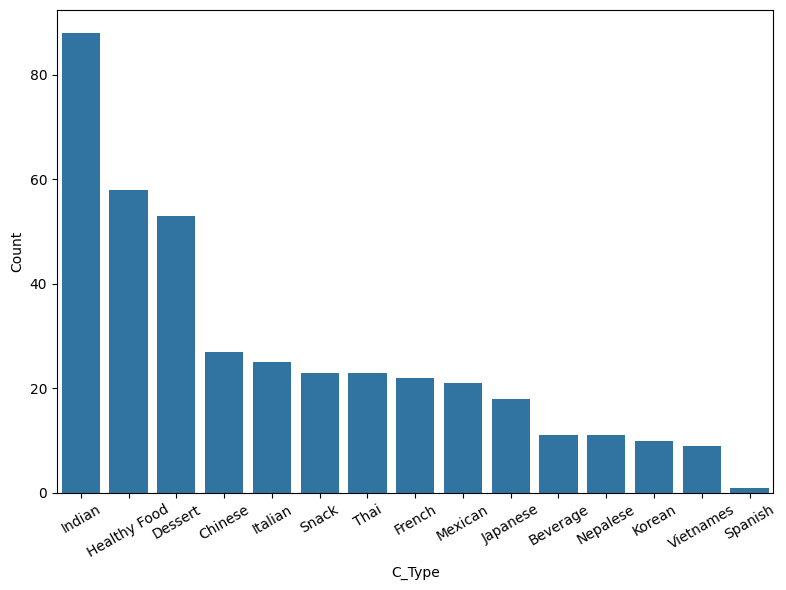

In [14]:
group_c_type = foods.groupby('C_Type')['C_Type'].agg('count').to_frame()
group_c_type = group_c_type.rename(columns={'C_Type': 'Count'})
group_c_type = group_c_type.sort_values(by='Count', ascending=False)
print(group_c_type.head(), '\n')

plt.figure(figsize=(8,6))

sns.barplot(x=group_c_type.index, y='Count', data=group_c_type)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Tipe masakan indian, healthy food, dan dessert merupakan top 3 untuk tipe masakan pada dataset.

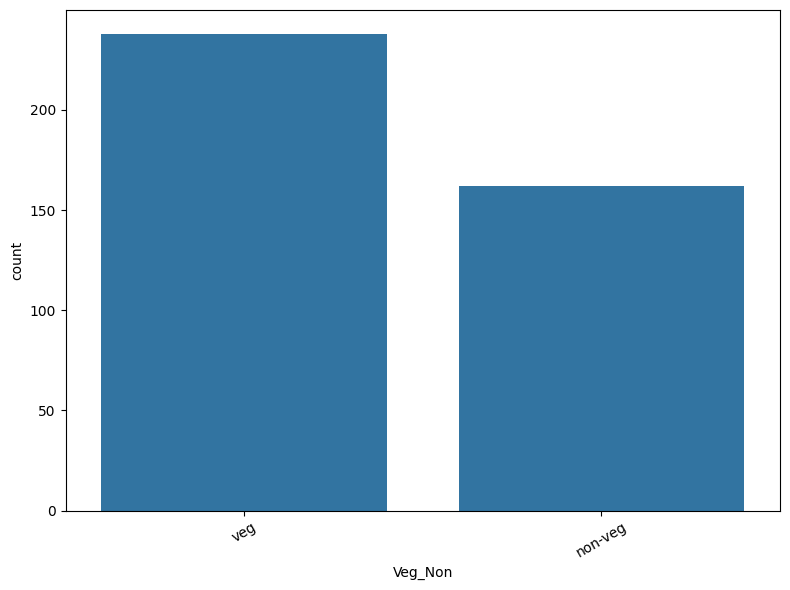

In [15]:
plt.figure(figsize=(8,6))

sns.countplot(x='Veg_Non', data=foods)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

**Ratings Datasets**

In [16]:
ratings.sample(5)

,User_ID,Food_ID,Rating
322,61.0,45.0,3.0
476,94.0,243.0,5.0
377,71.0,137.0,1.0
347,66.0,192.0,7.0
6,2.0,106.0,9.0


In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User_ID  511 non-null    float64
 1   Food_ID  511 non-null    float64
 2   Rating   511 non-null    float64
dtypes: float64(3)
memory usage: 12.1 KB


In [18]:
ratings.describe()

,User_ID,Food_ID,Rating
count,511.000000,511.000000,511.000000
mean,49.068493,125.311155,5.438356
std,28.739213,91.292629,2.866236
min,1.000000,1.000000,1.000000
25%,25.000000,45.500000,3.000000
50%,49.000000,111.000000,5.000000
75%,72.000000,204.000000,8.000000
max,100.000000,309.000000,10.000000


Dalam data, terdapat 511 baris data untuk fitur User_ID dan Food_ID, namun rentang nilai untuk masing-masing hanya mencakup 1 hingga 100 dan 1 hingga 309. Hal ini mengindikasikan bahwa beberapa pelanggan memberikan rating lebih dari sekali, begitu pula dengan makanan yang mendapatkan rating lebih dari sekali. Selain itu, fitur Rating menampilkan skala nilai dari 1 (terendah) hingga 10 (tertinggi).

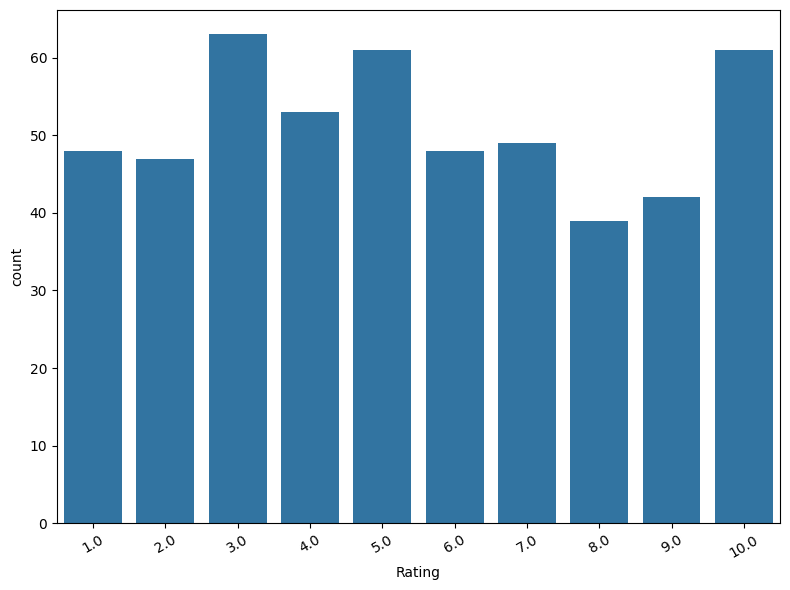

In [19]:
plt.figure(figsize=(8,6))

sns.countplot(x='Rating', data=ratings)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [20]:
rate_up = ratings[ratings['Rating'] >= 8]
rate_up['Food_ID'].value_counts().head(5)

49.0     3
7.0      3
186.0    3
136.0    2
25.0     2
Name: Food_ID, dtype: int64

In [21]:
rate_down = ratings[ratings['Rating'] <= 3]
rate_down['Food_ID'].value_counts().head(5)

23.0     4
49.0     3
22.0     3
163.0    3
225.0    2
Name: Food_ID, dtype: int64

## Content Based Filtering

In [22]:
features = ['C_Type', 'Veg_Non', 'Describe']
foods[features]

,C_Type,Veg_Non,Describe
0,Healthy Food,veg,"white balsamic vinegar, lemon juice, lemon rin..."
1,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni..."
2,Snack,veg,"almonds whole, egg white, curry leaves, salt, ..."
3,Healthy Food,veg,"vinegar, honey/sugar, soy sauce, salt, garlic ..."
4,Dessert,veg,"christmas dry fruits (pre-soaked), orange zest..."
...,...,...,...
395,Korean,veg,"cream cheese, chopped kimchi, scallions,count..."
396,Mexican,non-veg,"poblano chiles, bacon, shrips, red salsa, garl..."
397,French,non-veg,"broccoli,Bread Crumbs, anchovy fillets, garli..."
398,Dessert,non-veg,"egg yolks,lemon juice, unsalted butter, all pu..."


In [23]:
foods['soup'] = foods[features].apply(lambda x: ' '.join(x), axis=1)
foods['soup'] = foods['soup'].apply(lambda x: x.lower())
foods.sample(5)

,Food_ID,Name,C_Type,Veg_Non,Describe,soup
325,326,Pho Chay Soup,Vietnames,veg,"Rice noodle,vegatable soup, bean curd, mushroom","vietnames veg rice noodle,vegatable soup, bean..."
344,345,Cucumber and Radish Salad,Healthy Food,veg,"cucumber,raddish,vinegar, coriander,olive, sal...","healthy food veg cucumber,raddish,vinegar, cor..."
276,277,microwave chocolate cake,Dessert,veg,"Flour, castor or powdered sugar, oil, butter o...","dessert veg flour, castor or powdered sugar, o..."
381,382,Eggplant and Beef Stir-Fry,Thai,non-veg,"soya sauce,mint,thai chillies,vermicelli noodl...","thai non-veg soya sauce,mint,thai chillies,ver..."
339,340,Sukuti Chatpate,Nepalese,non-veg,"crunchy noodles, onion, cucumber,tomatoes, lem...","nepalese non-veg crunchy noodles, onion, cucum..."


In [62]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(foods['soup'])

In [63]:
count.get_feature_names_out()

array(['10', '13', '150', ..., 'zested', 'zinfandel', 'zucchini'],
      dtype=object)

In [64]:
count_matrix.todense()

matrix([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [65]:
cosine_sim = cosine_similarity(count_matrix)
cosine_sim

array([[1.        , 0.37282186, 0.25253814, ..., 0.32084447, 0.20203051,
        0.39036003],
       [0.37282186, 1.        , 0.17574991, ..., 0.3588535 , 0.17574991,
        0.42447636],
       [0.25253814, 0.17574991, 1.        , ..., 0.12964074, 0.21428571,
        0.13801311],
       ...,
       [0.32084447, 0.3588535 , 0.12964074, ..., 1.        , 0.12964074,
        0.31311215],
       [0.20203051, 0.17574991, 0.21428571, ..., 0.12964074, 1.        ,
        0.06900656],
       [0.39036003, 0.42447636, 0.13801311, ..., 0.31311215, 0.06900656,
        1.        ]])

In [66]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=foods['Name'], columns=foods['Name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (400, 400)


Name,shepherds salad (tamatar-kheera salaad),tricolour salad,mixed salad with lotus root,roast turkey with cranberry sauce,Alo Tama Bodi
Name,,,,,
corn and raw mango salad,0.417620,0.228665,0.171499,0.192748,0.148522
lemon rice,0.196722,0.175035,0.105021,0.078689,0.060634
braised lamb shanks,0.229416,0.081650,0.081650,0.229416,0.070711
duo of chocolate and strawberry,0.076472,0.068041,0.068041,0.076472,0.117851
chicken dragon,0.200250,0.133631,0.133631,0.200250,0.077152
fish salan,0.183942,0.136386,0.081832,0.183942,0.094491
malabar fish curry,0.123613,0.073324,0.109985,0.123613,0.063500
bengali lamb curry,0.247226,0.146647,0.109985,0.206021,0.063500
fish andlouse,0.408400,0.266476,0.072675,0.353946,0.083918


In [75]:
def food_recommendations(nama_makanan, similarity_data=cosine_sim_df, items=foods[['Name', 'C_Type', 'Veg_Non']], k=5):

    index = similarity_data.loc[:,nama_makanan].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(nama_makanan, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [76]:
foods.sample(1)

,Food_ID,Name,C_Type,Veg_Non,Describe,soup
75,76,holi special ice tea thandai,Beverage,veg,"ground white pepper (kali mirch), assam tea ba...","beverage veg ground white pepper (kali mirch),..."


In [77]:
food_recommendations('holi special ice tea thandai')

,Name,C_Type,Veg_Non
0,spiced coffee,Beverage,veg
1,gajar tart,French,veg
2,homemade gulab jamun,Dessert,veg
3,flax seed and beetroot modak,Japanese,veg
4,almond pearls,Snack,veg


## Collaborative Filtering

In [161]:
ratings.isna().sum()

User_ID    1
Food_ID    1
Rating     1
dtype: int64

In [162]:
ratings.dropna(inplace=True)
ratings.isna().sum()

User_ID    0
Food_ID    0
Rating     0
dtype: int64

In [163]:
ratings.sample(5)

,User_ID,Food_ID,Rating
13,3.0,46.0,2.0
450,88.0,210.0,2.0
381,71.0,307.0,1.0
282,53.0,22.0,3.0
87,16.0,282.0,10.0


In [164]:
num_user = ratings['User_ID'].nunique()
num_food = foods['Food_ID'].nunique()

min_rating = ratings['Rating'].min()
max_rating = ratings['Rating'].max()

In [284]:
# Mengacak dataset
ratings = ratings.sample(frac=1, random_state=42)
ratings

,User_ID,Food_ID,Rating
442,86.0,237.0,4.0
280,53.0,190.0,10.0
419,80.0,306.0,8.0
10,3.0,168.0,1.0
302,56.0,305.0,9.0
...,...,...,...
390,74.0,44.0,6.0
239,46.0,236.0,4.0
240,46.0,68.0,4.0
205,39.0,195.0,4.0


In [285]:
x = ratings[['User_ID', 'Food_ID']].values

# Membuat variabel y untuk membuat rating dari hasil
y = ratings['Rating'].apply(lambda x: round((x - min_rating) / (max_rating - min_rating), 2)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 86. 237.]
 [ 53. 190.]
 [ 80. 306.]
 ...
 [ 46.  68.]
 [ 39. 195.]
 [ 62.  58.]] [0.33 1.   0.78 0.   0.89 0.22 0.44 1.   0.78 0.11 0.44 0.33 0.56 0.78
 0.78 0.33 0.89 0.11 0.67 0.89 0.11 0.22 0.78 0.44 0.44 0.44 0.78 1.
 0.89 0.89 0.33 0.33 0.89 0.11 1.   0.44 1.   0.22 0.44 0.44 0.78 0.22
 0.89 1.   0.22 0.67 1.   0.22 0.   0.56 0.22 0.78 0.67 0.44 0.56 0.
 0.78 0.78 0.44 0.67 1.   0.56 0.33 0.11 1.   0.56 0.44 1.   0.22 0.67
 0.67 0.   0.56 0.44 0.67 1.   0.67 0.56 1.   1.   0.22 1.   0.22 0.44
 0.44 0.22 0.11 1.   0.44 0.56 0.78 0.67 0.11 0.   0.33 0.67 0.89 1.
 0.11 0.56 0.67 0.33 0.56 0.44 0.67 0.22 0.44 1.   0.33 0.11 0.44 0.78
 0.   0.   0.33 0.44 0.67 0.11 0.44 0.44 0.22 0.11 0.11 0.89 0.89 0.78
 0.89 0.44 0.67 0.56 0.44 0.44 1.   0.78 1.   0.44 1.   0.22 0.11 0.33
 0.11 1.   0.78 0.33 0.   1.   0.22 0.22 0.44 0.11 0.33 0.56 0.22 0.44
 0.22 0.44 0.56 0.22 0.78 0.56 1.   0.   0.44 0.22 0.11 0.44 0.89 1.
 0.44 0.11 1.   0.11 0.56 0.44 0.11 0.44 0.22 0.56 0.89 0.44 0.   0.78
 

In [286]:
class RecommenderNet(tf.keras.Model):

    # Insialisasi fungsi
    def __init__(self, num_users, num_resto, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_resto = num_resto
        self.embedding_size = embedding_size
        self.user_embedding = tf.keras.layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='glorot_uniform',  # Menggunakan glorot_uniform
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.user_bias = tf.keras.layers.Embedding(num_users, 1)
        self.resto_embedding = tf.keras.layers.Embedding(
            num_resto,
            embedding_size,
            embeddings_initializer='glorot_uniform',  # Menggunakan glorot_uniform
            embeddings_regularizer=tf.keras.regularizers.l1_l2(1e-6)
        )
        self.resto_bias = tf.keras.layers.Embedding(num_resto, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        resto_vector = self.resto_embedding(inputs[:, 1])
        resto_bias = self.resto_bias(inputs[:, 1])

        dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)
        x = dot_user_resto - (user_bias + resto_bias)

        return tf.nn.sigmoid(x)

In [290]:
model = RecommenderNet(num_user+1, num_food+1, 100) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [291]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
26/26 [==============================] - 1s 13ms/step - loss: 2.2983 - root_mean_squared_error: 0.3223 - val_loss: 2.2957 - val_root_mean_squared_error: 0.3339
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 2.2799 - root_mean_squared_error: 0.3210 - val_loss: 2.2791 - val_root_mean_squared_error: 0.3339
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 2.2587 - root_mean_squared_error: 0.3174 - val_loss: 2.2627 - val_root_mean_squared_error: 0.3338
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 2.2497 - root_mean_squared_error: 0.3229 - val_loss: 2.2464 - val_root_mean_squared_error: 0.3338
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 2.2346 - root_mean_squared_error: 0.3237 - val_loss: 2.2303 - val_root_mean_squared_error: 0.3337
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 2.2196 - root_mean_squared_error: 0.3244 - val_loss: 2.2144 - val_root_

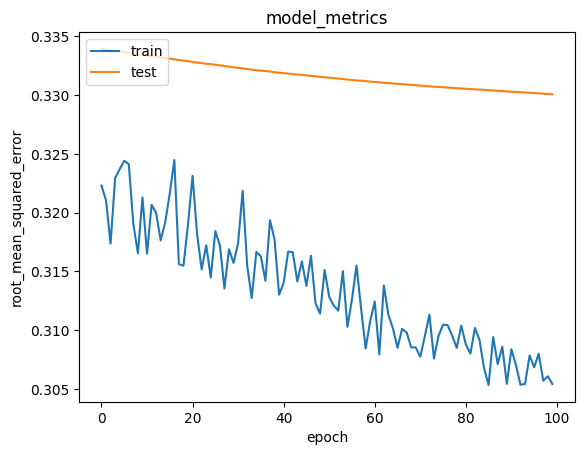

In [292]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [293]:
# Mengambil sample user
user_id = ratings['User_ID'].sample(1).iloc[0]
food_by_user = ratings[ratings['User_ID'] == user_id]

food_not_rate = foods[~foods['Food_ID'].isin(food_by_user['Food_ID'].values)]['Food_ID']
food_not_rate = list(
    set(food_not_rate)
    .intersection(set(foods['Food_ID']))
)

resto_not_visited = [[x] for x in food_not_rate]
user_resto_array = np.hstack(
    ([[user_id]] * len(resto_not_visited), resto_not_visited)
)

In [294]:
rate = model.predict(user_resto_array).flatten()

top_ratings_indices = rate.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_not_visited[x][0] for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Resto with high ratings from user')
print('----' * 8)

top_resto_user = (
    food_by_user.sort_values(
        by = 'Rating',
        ascending=False
    )
    .head(5)
    ['Food_ID'].values
)

resto_df_rows = foods[foods['Food_ID'].isin(top_resto_user)]
for row in resto_df_rows.itertuples():
    print(row.Name, ':', row.C_Type)

print('----' * 8)
print('Top 10 resto recommendation')
print('----' * 8)

recommended_resto = foods[foods['Food_ID'].isin(recommended_resto_ids)]
for row in recommended_resto.itertuples():
    print(row.Name, ':', row.C_Type)

13/13 [==============================] - 0s 2ms/step
Showing recommendations for users: 43.0
Resto with high ratings from user
--------------------------------
japanese curry arancini with barley salsa : Japanese
mixed berry & banana smoothie : Healthy Food
garlic and pinenut soup with burnt butter essence : French
kale channe ki biryani : Indian
berry parfait hazelnut white chocolate sable : Dessert
--------------------------------
Top 10 resto recommendation
--------------------------------
summer squash salad : Healthy Food
chocolate nero cookies : Dessert
broccoli and almond soup : Healthy Food
watermelon and strawberry smoothie : Healthy Food
grilled almond barfi : Dessert
spinach and feta crepes : French
couscous with ratatouille - tangy tomato sauce : French
christmas dry fruit cake : Dessert
cheese and ham roll : Snack
ragi coconut ladoo (laddu) : Dessert


## Reference

[1] J. Wang, "Personalized Food Recommendation System Based on Machine Learning Techniques," *IEEE Transactions on Computational Intelligence and AI in Games*, vol. 8, no. 2, pp. 156-169, 2023.